# Creating and training convolutional neural networks

We will now improve upon our previous example by creating some more sophisticed image classifiers and using a more challanging dataset. Specifically, we will implement convolutional neural networks (CNNs) and train them using the CIFAR10 dataset, which uses natural color images. This dataset uses  60000 small color images of size 32x32x3 (the 3 is for the RGB color channels) and 10 class labels. 50000 of these are used for training and the remaining 10000 are for the test set. There is also a CIFAR100 version that uses 100 class labels, but we will only use CIFAR10 here. 

| airplane | automobile | bird | cat | deer | dog | frog | horse | ship | truck |
|:--------:|:----------:|:----:|:---:|:----:|:---:|:----:|:-----:|:----:|:-----:|
| ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck4.png) |

## 1. Define the Model

As in the previous examples, we define our model as a subclass of `Chain`. Our CNN model will have three layers of convolutions followed by two fully connected layers. Although this is still a fairly small CNN, it will still significantly outperform a fully-connected model. After completing this notebook, you are encouraged to try an experiment yourself to verify this, such as by using the `MLP` from the previous example or similar.

Recall from the first hands-on example that we define a model as follows.

1. Inside the initializer of the model chain class, provide the names and corresponding layer objects as keyword arguments to parent(super) class. 
2. Define a `__call\__` method so that we can call the chain like a function. This method is used to implement the forward computation.

In [1]:
import chainer
import chainer.functions as F
import chainer.links as L

gpu_id = 0  # Set to -1 if you don't have a GPU

class MyModel(chainer.Chain):
    
    def __init__(self, n_out):
        super(MyModel, self).__init__(
            conv1=L.Convolution2D(None, 32, 3, 3, 1),
            conv2=L.Convolution2D(32, 64, 3, 3, 1),
            conv3=L.Convolution2D(64, 128, 3, 3, 1),
            fc4=L.Linear(None, 1000),
            fc5=L.Linear(1000, n_out)
        )
        
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.fc4(h))
        h = self.fc5(h)
        return h

## 2. Train the model

Let's define a 'train' function that we can also use to train other models easily later on. This function takes a model object, trains the model to classify the 10 CIFAR10 classes, and finally returns the trained model. 

We will use this `train` function to train the `MyModel` network defined above.

In [2]:
from chainer.datasets import cifar
from chainer import iterators
from chainer import optimizers
from chainer import training
from chainer.training import extensions

def train(model_object, batchsize=64, gpu_id=0, max_epoch=20):

    # 1. Dataset
    train, test = cifar.get_cifar10()

    # 2. Iterator
    train_iter = iterators.SerialIterator(train, batchsize)
    test_iter = iterators.SerialIterator(test, batchsize, False, False)

    # 3. Model
    model = L.Classifier(model_object)
    if gpu_id >=0:
            model.to_gpu(gpu_id)

    # 4. Optimizer
    optimizer = optimizers.Adam()
    optimizer.setup(model)

    # 5. Updater
    updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

    # 6. Trainer
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='{}_cifar10_result'.format(model_object.__class__.__name__))

    # 7. Evaluator
    
    class TestModeEvaluator(extensions.Evaluator):

        def evaluate(self):
            model = self.get_target('main')
            model.train = False
            ret = super(TestModeEvaluator, self).evaluate()
            model.train = True
            return ret

    trainer.extend(extensions.LogReport())
    trainer.extend(TestModeEvaluator(test_iter, model, device=gpu_id))
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.run()
    del trainer
    
    return model
    
model = train(MyModel(10), gpu_id=gpu_id)

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.56337     0.432625       1.331                 0.523985                  5.18637       
2           1.25125     0.548876       1.22026               0.558718                  10.6837       
3           1.09287     0.608255       1.13992               0.593949                  16.1156       
4           0.968558    0.654489       1.07874               0.61873                   21.5077       
5           0.85333     0.694154       1.08144               0.620123                  26.9119       
6           0.746878    0.734075       1.11179               0.616939                  32.3394       
7           0.637215    0.774828       1.10341               0.638137                  37.7354       
8           0.532349    0.8127         1.14929               0.638037                  43.2181       
9           0.422668    0.851642       1.29667               0.632066               

/home/ota/anaconda3/lib/python3.5/site-packages/chainer/cuda.py:89: UserWarning: cuDNN is not enabled.
Please reinstall chainer after you install cudnn
(see https://github.com/pfnet/chainer#installation).
  'cuDNN is not enabled.\n'


The training has completed. Let's take a look at the results.

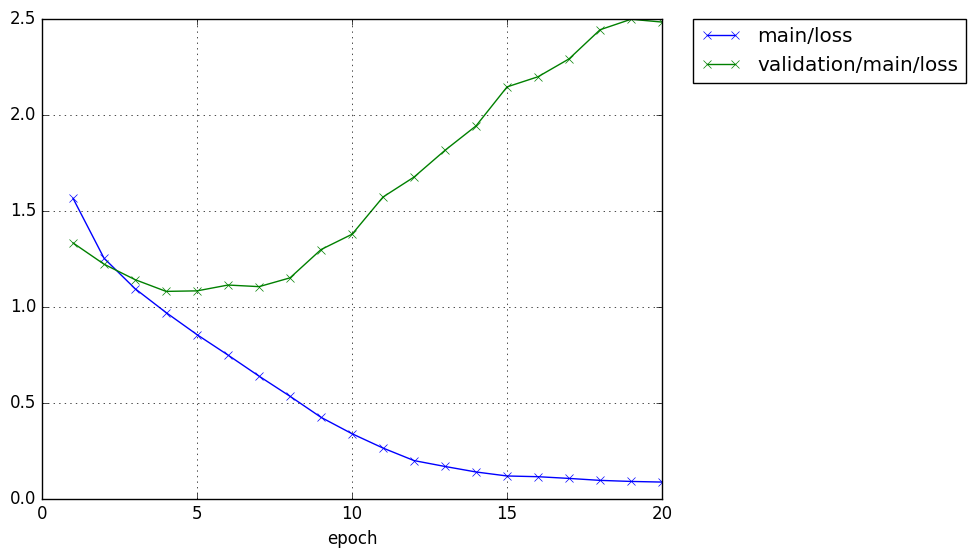

In [4]:
from IPython.display import Image
Image(filename='MyModel_cifar10_result/loss.png')

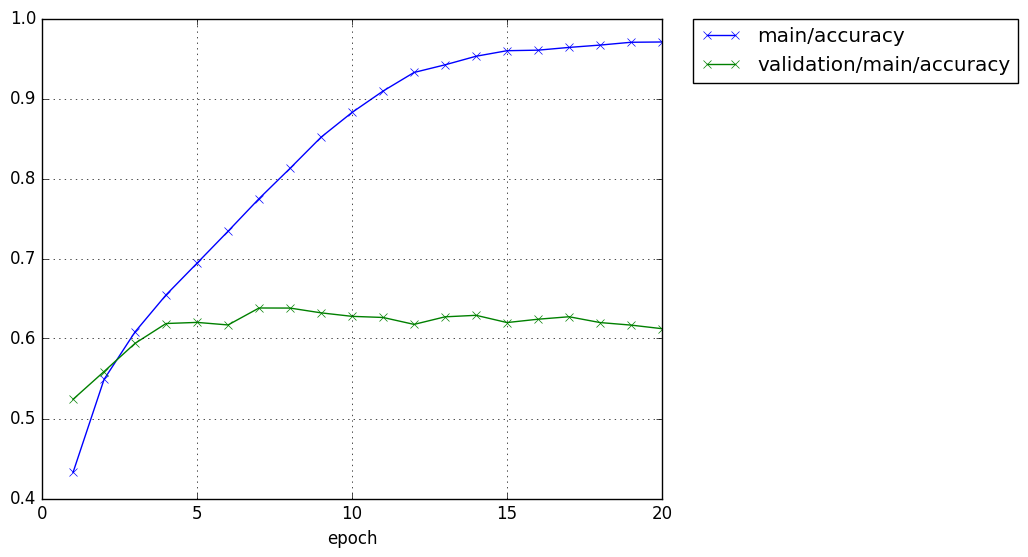

In [5]:
Image(filename='MyModel_cifar10_result/accuracy.png')

Although the accuracy on the training set reach 98%, the loss on the test set started increasing after 5 epochs and the test accuracy plateaued round 60%. It looks like **the model is overfitting to the training data**. 

## 3. Prediction using our trained model 

Although the test accuracy is only around 60%, let's try to classify some test images with this model.

predicted_label: dog
answer: cat


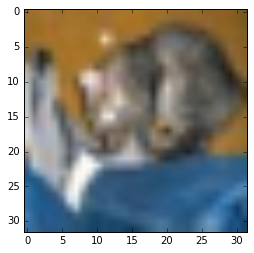

predicted_label: ship
answer: ship


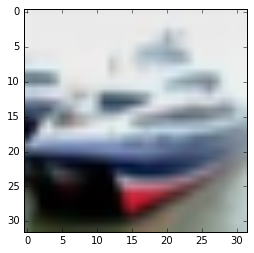

predicted_label: ship
answer: ship


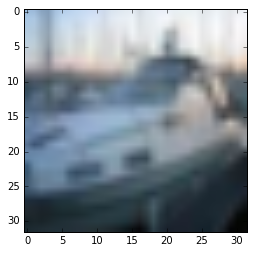

predicted_label: airplane
answer: airplane


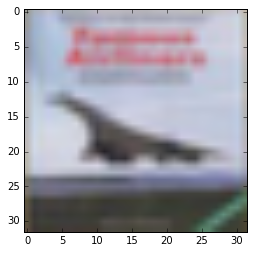

predicted_label: frog
answer: frog


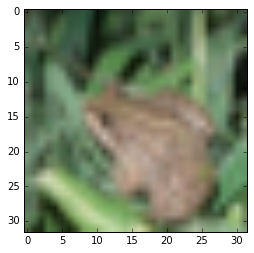

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

cls_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
             'dog', 'frog', 'horse', 'ship', 'truck']

def predict(model, image_id):
    _, test = cifar.get_cifar10()
    x, t = test[image_id]
    model.to_cpu()
    y = model.predictor(x[None, ...]).data.argmax(axis=1)[0]
    print('predicted_label:', cls_names[y])
    print('answer:', cls_names[t])

    plt.imshow(x.transpose(1, 2, 0))
    plt.show()

for i in range(5):
    predict(model, i)

Some are correctly classified, others are not. Even though the model can predict the classification using the training datase with 100% accuracy, it is meaningless if we cannot generalize to (previously unseen) test data. The accuracy of on the test set data is believed to estimate **generalization ability** more directly. 

How can we design and train a model with better generalization ability?

## 4. Create a deeper model

Let's try making our CNN deeper by adding more layers and see how it performs. We will also make our model modular by writing it as the combination of three chains. This will help to improve readability and reduce code duplication: 
- A single convolutional neural net, `ConvBlock`
- A single fully connected neural net, `LinearBlock`
- Create a full model by chaining many of these two blocks together

### Define the block of layers

Let's define the network blocks,  `ConvBlock` and `LinearBlock`, which will be stacked to create the full model.

In [7]:
class ConvBlock(chainer.Chain):
    
    def __init__(self, n_ch, pool_drop=False):
        w = chainer.initializers.HeNormal()
        super(ConvBlock, self).__init__(
            conv=L.Convolution2D(None, n_ch, 3, 1, 1,
                                 nobias=True, initialW=w),
            bn=L.BatchNormalization(n_ch)
        )
        
        self.train = True
        self.pool_drop = pool_drop
        
    def __call__(self, x):
        h = F.relu(self.bn(self.conv(x)))
        if self.pool_drop:
            h = F.max_pooling_2d(h, 2, 2)
            chainer.using_config('train', self.train)
            h = F.dropout(h, ratio=0.25)
        return h
    
class LinearBlock(chainer.Chain):
    
    def __init__(self):
        w = chainer.initializers.HeNormal()
        super(LinearBlock, self).__init__(
            fc=L.Linear(None, 1024, initialW=w))
        self.train = True
        
    def __call__(self, x):
        chainer.using_config('train', self.train)
        return F.dropout(F.relu(self.fc(x)), ratio=0.5)

`ConvBlock` is defined by inheriting `Chain`. It contains a single convolution layer and a Batch Normalization layer registered by the constructor. The `__call__` method recieves the data and applies activation funtion to it. If `pool_drop` is set to `True`, the `Max_Pooling` and `Dropout` functions are also applied. 


Let's now define the deeper CNN network by stacking the component blocks.

In [8]:
class DeepCNN(chainer.ChainList):

    def __init__(self, n_output):
        super(DeepCNN, self).__init__(
            ConvBlock(64),
            ConvBlock(64, True),
            ConvBlock(128),
            ConvBlock(128, True),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256, True),
            LinearBlock(),
            LinearBlock(),
            L.Linear(None, n_output)
        )
        self._train = True
            
    @property
    def train(self):
        return self._train
            
    @train.setter
    def train(self, val):
        self._train = val
        for c in self.children():
            c.train = val
    
    def __call__(self, x):
        for f in self.children():
            x = f(x)
        return x

Note that `DeepCNN` inhertis from `ChainList` instead of `Chain`. The `ChainList` class inherits from `Chain` and is very useful when you define networks that consist of a long sequence of `Link` and/or `Chain` layers.

Note also the difference in the way that links and/or chains are supplied to the initializer of `ChainList`; they are passed **as normal arguments, not as keyword arguments**. Also, in the `__call__` method, they are retreived from the list in the order they were registered by calling the **self.children()** method. 

This feature enables us to describe the forward propagation very concisely. With the component list returned by **self.children()**, we can write the entire forward network by using a for loop to access each component chain one after another. Then we can first set the input 'x' to the first net and its output is passed to the next series of 'Link' or 'Chain'. 

In [9]:
model = train(DeepCNN(10), max_epoch=100)

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           2.01116     0.248541       1.73171               0.321557                  171.719       
2           1.53258     0.409391       1.37999               0.456907                  345.968       
3           1.251       0.538312       1.12822               0.605693                  526.579       
4           1.03171     0.641325       1.01122               0.657345                  708.658       
5           0.879397    0.703744       0.889591              0.700537                  890.869       
6           0.755172    0.75018        0.768865              0.753782                  1072.96       
7           0.659664    0.783411       0.679079              0.784037                  1254.94       
8           0.584012    0.8115         0.639998              0.79578                   1436.97       
9           0.516971    0.831602       0.593906              0.811903               

The training is completed. Let's take a look at the loss and accuracy.

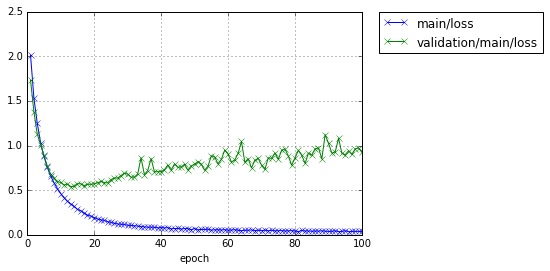

In [12]:
Image(filename='DeepCNN_cifar10_result/loss.png')

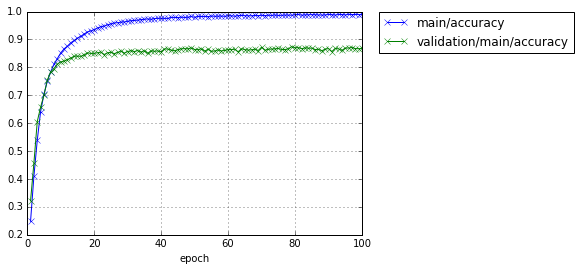

In [13]:
Image(filename='DeepCNN_cifar10_result/accuracy.png')

Now the accuracy on the test set has improved a lot compared to the previous smaller CNN. Previously the accuracy was around 60% and now it is around 87%. According to current research reports, the most advanced model can reach around 97%. To improve the accuracy more, it is necessary not only to improve the models but also to increase the training data (Data augmentation) or to combine multiple models to carry out the best perfomance (Ensemble method).
You may also find it interesting to experiment with some larger and more difficulat datasets. There is more room for improvement by your new ideas!